# GAN with MNIST

* MNIST data를 가지고 **Generative Adversarial Networks**를 `tf.contrib.slim`을 이용하여 만들어보자.
  * [참고: TensorFlow slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf

slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

#tf.set_random_seed(219)
#np.random.seed(219)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Training Flags (hyperparameter configuration)
train_dir = 'train/gan/exp1/'
max_epochs = 100
save_epochs = 20
summary_steps = 5000
print_steps = 2500
batch_size = 32
learning_rate_D = 0.0002
learning_rate_G = 0.0002
k = 1 # the number of step of learning D before learning G
num_samples = 16

## Import MNIST

In [3]:
# Load training and eval data from tf.keras
(train_data, train_labels), _ = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data
train_data = train_data / 255.
train_data = train_data.reshape([-1, 28*28])
train_labels = np.asarray(train_labels, dtype=np.int32)

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count=max_epochs)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

<BatchDataset shapes: (?, 784), types: tf.float64>


## Create the model

In [5]:
class GAN_model(object):
  """Generative Adversarial Networks
  implementation based on http://arxiv.org/abs/1406.2661
  
  "Generative Adversarial Nets"
  Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu,
  David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio
  """
  
  def __init__(self, mode, train_dataset, test_dataset=None):
    """Basic setup.
    
    Args:
      mode (`string`): "train" or "generate"
      train_dataset (`tf.data.Dataset`): train_dataset
      test_dataset (`tf.data.Dataset`): test_dataset
    """
    assert mode in ["train", "generate"]
    self.mode = mode
    
    # hyper-parameters for model
    self.x_dim = 784
    self.z_dim = 100
    self.batch_size = batch_size
    self.num_samples = num_samples
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    
    # Global step Tensor.
    self.global_step = None
    
    print('The mode is %s.' % self.mode)
    print('complete initializing model.')
    
    
  def build_random_z_inputs(self):
    """Build a vector random_z in latent space.
    
    Returns:
      self.random_z (`2-rank Tensor` with [batch_size, z_dim]):
          latent vector which size is generally 100 dim.
      self.sample_random_z (`2-rank Tensor` with [num_samples, z_dim]):
          latent vector which size is generally 100 dim.
    """
    # Setup variable of random vector z
    with tf.variable_scope('random_z'):
      #self.random_z = tf.placeholder(tf.float32, [None, self.z_dim])
      self.random_z = tf.random_uniform([self.batch_size, self.z_dim], minval=-1.0, maxval=1.0)
      self.sample_random_z = tf.random_uniform([self.num_samples, self.z_dim], minval=-1.0, maxval=1.0)

    return self.random_z, self.sample_random_z
  
  
  def read_MNIST(self, dataset):
    """Read MNIST dataset
    
    Args:
      dataset (`tf.data.Dataset` format): MNIST dataset
      
    Returns:
      self.mnist (`2-rank Tensor` with [batch, x_dim]): MNIST dataset with batch size
    """
    with tf.variable_scope('mnist'):
      iterator = dataset.make_one_shot_iterator()

      self.mnist = iterator.get_next()
      self.mnist = tf.cast(self.mnist, dtype = tf.float32)
      
    return self.mnist


  def Generator(self, random_z, reuse=False):
    """Generator setup.
    
    Args:
      random_z (`2-rank Tensor` with [batch_size, z_dim]):
          latent vector which size is generally 100 dim.
      reuse (`bool`): whether variable reuse or not
      
    Returns:
      generated_data (`4-rank Tensor` with [batch_size, h, w, c])
          generated images from random vector z
    """
    with tf.variable_scope('Generator', reuse=reuse) as scope:
      with slim.arg_scope([slim.fully_connected],
                          activation_fn=tf.nn.leaky_relu):
        # inputs = random_z: 100 dim
        self.layer1 = slim.fully_connected(inputs=random_z,
                                           num_outputs=256,
                                           scope='layer1')
        # layer1: 256 dim
        self.layer2 = slim.fully_connected(inputs=self.layer1,
                                           num_outputs=512,
                                           scope='layer2')
        # layer2: 512 dim
        self.layer3 = slim.fully_connected(inputs=self.layer2,
                                           num_outputs=1024,
                                           scope='layer3')
        # layer3: 1024 dim
        self.layer4 = slim.fully_connected(inputs=self.layer3,
                                           num_outputs=self.x_dim,
                                           activation_fn=tf.sigmoid,
                                           scope='layer4')
        # output = layer4: x_dim (784)
        generated_data = self.layer4

        return generated_data
    
    
  def Discriminator(self, data, reuse=False):
    """Discriminator setup.
    
    Args:
      data (`2-rank Tensor` with [batch_size, x_dim]): MNIST real data
      reuse (`bool`): whether variable reuse or not
      
    Returns:
      logits (`1-rank Tensor` with [batch_size]): logits of data 
    """
    with tf.variable_scope('Discriminator', reuse=reuse) as scope:
      with slim.arg_scope([slim.fully_connected],
                          activation_fn=tf.nn.leaky_relu):
        with slim.arg_scope([slim.dropout], keep_prob=0.7):
          # data: x_dim (784)
          self.layer1 = slim.fully_connected(inputs=data,
                                             num_outputs=1024,
                                             scope='layer1')
          self.layer1_drop = slim.dropout(inputs=self.layer1, scope='drop1')
          # layer1: 1024 dim
          self.layer2 = slim.fully_connected(inputs=self.layer1_drop,
                                             num_outputs=512,
                                             scope='layer2')
          self.layer2_drop = slim.dropout(inputs=self.layer2, scope='drop2')
          # layer2: 512 dim
          self.layer3 = slim.fully_connected(inputs=self.layer2_drop,
                                             num_outputs=256,
                                             scope='layer3')
          self.layer3_drop = slim.dropout(inputs=self.layer3, scope='drop3')
          # layer3: 256 dim
          self.layer4 = slim.fully_connected(inputs=self.layer3_drop,
                                             num_outputs=1,
                                             activation_fn=None,
                                             scope='layer4')
          # logits = layer4: 1 dim
          discriminator_logits = self.layer4

          return discriminator_logits
    
    
  def setup_global_step(self):
    """Sets up the global step Tensor."""
    if self.mode == "train":
      #self.global_step = tf.Variable(initial_value=0,
      #                               name='global_step',
      #                               trainable=False,
      #                               collections=[tf.GraphKeys.GLOBAL_STEP,
      #                                            tf.GraphKeys.GLOBAL_VARIABLES])
      self.global_step = tf.train.get_or_create_global_step()
      
      print('complete setup global_step.')
      
      
  def GANLoss(self, logits, is_real=True, scope=None):
    """Computes standard GAN loss between `logits` and `labels`.
    
    Args:
      logits (`1-rank Tensor`): logits.
      is_real (`bool`): True means `1` labeling, False means `0` labeling.
      
    Returns:
      loss (`0-randk Tensor): the standard GAN loss value. (binary_cross_entropy)
    """
    if is_real:
      labels = tf.ones_like(logits)
    else:
      labels = tf.zeros_like(logits)

    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                           logits=logits,
                                           scope=scope)

    return loss

      
  def build(self):
    """Creates all ops for training or generate."""
    self.setup_global_step()
    
    if self.mode == "generate":
      pass
    
    else:
      # generating random vector
      self.random_z, self.sample_random_z = self.build_random_z_inputs()
      # generating images from Generator() via random vector z
      self.generated_data = self.Generator(self.random_z)
      
      # read dataset
      self.real_data = self.read_MNIST(self.train_dataset)
      
      # discriminating real data by Discriminator()
      self.real_logits = self.Discriminator(self.real_data)
      # discriminating fake data (generated)_images) by Discriminator()
      self.fake_logits = self.Discriminator(self.generated_data, reuse=True)
      
      # losses of real with label "1"
      self.loss_real = self.GANLoss(logits=self.real_logits, is_real=True, scope='loss_D_real')
      # losses of fake with label "0"
      self.loss_fake = self.GANLoss(logits=self.fake_logits, is_real=False, scope='loss_D_fake')
      
      # losses of Discriminator
      with tf.variable_scope('loss_D'):
        self.loss_Discriminator = self.loss_real + self.loss_fake
      # losses of Generator with label "1" that used to fool the Discriminator
      self.loss_Generator = self.GANLoss(logits=self.fake_logits, is_real=True, scope='loss_G')
      
      # Separate variables for each function
      self.D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
      self.G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
      
      
      # generating images for sample
      self.sample_data = self.Generator(self.sample_random_z, reuse=True)
      
      # write summaries
      # Add loss summaries
      tf.summary.scalar('losses/loss_Discriminator', self.loss_Discriminator)
      tf.summary.scalar('losses/loss_Generator', self.loss_Generator)
      
      # Add histogram summaries
      for var in self.D_vars:
        tf.summary.histogram(var.op.name, var)
      for var in self.G_vars:
        tf.summary.histogram(var.op.name, var)
      
      # Add image summaries
      tf.summary.image('random_images', tf.reshape(self.generated_data, [-1, 28, 28, 1]), max_outputs=4)
      tf.summary.image('real_images', tf.reshape(self.real_data, [-1, 28, 28, 1]))
      
    print('complete model build.\n')

## Define plot function

In [6]:
def print_sample_data(sample_data, max_print=num_samples):
  print_images = sample_data[:max_print,:]
  print_images = print_images.reshape([max_print, 28, 28])
  print_images = print_images.swapaxes(0, 1)
  print_images = print_images.reshape([28, max_print * 28])
  
  plt.figure(figsize=(max_print, 1))
  plt.axis('off')
  plt.imshow(print_images, cmap='gray')
  plt.show()

## Build a model

In [7]:
model = GAN_model(mode="train", train_dataset=train_dataset)
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The mode is train.
complete initializing model.
complete setup global_step.
complete model build.

---------
Variables: name (type shape) [size]
---------
Generator/layer1/weights:0 (float32_ref 100x256) [25600, bytes: 102400]
Generator/layer1/biases:0 (float32_ref 256) [256, bytes: 1024]
Generator/layer2/weights:0 (float32_ref 256x512) [131072, bytes: 524288]
Generator/layer2/biases:0 (float32_ref 512) [512, bytes: 2048]
Generator/layer3/weights:0 (float32_ref 512x1024) [524288, bytes: 2097152]
Generator/layer3/biases:0 (float32_ref 1024) [1024, bytes: 4096]
Generator/layer4/weights:0 (float32_ref 1024x784) [802816, bytes: 3211264]
Generator/layer4/biases:0 (float32_ref 784) [784, bytes: 3136]
Discriminator/layer1/weights:0 (float32_ref 784x1024) [802816, bytes: 3211264]
Discriminator/layer1/biases:0 (float32_ref 1024) [1024, bytes: 4096]
Discriminator/layer2/weights:0 (float32_ref 1024x512) [524288, bytes: 2097152]
Discriminator/layer2/biases:0 (float32_ref 512) [512, bytes: 2048]
Di

(2946577, 11786308)

In [8]:
opt_D = tf.train.AdamOptimizer(learning_rate=learning_rate_D, beta1=0.5)
opt_G = tf.train.AdamOptimizer(learning_rate=learning_rate_G, beta1=0.5)

In [9]:
opt_D_op = opt_D.minimize(model.loss_Discriminator, var_list=model.D_vars)
opt_G_op = opt_G.minimize(model.loss_Generator, global_step=model.global_step,
                          var_list=model.G_vars)

### Assign `tf.summary.FileWriter`

In [10]:
graph_location = train_dir
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph()) 

Saving graph to: train/gan/exp1/


### `tf.summary`

In [11]:
summary_op = tf.summary.merge_all()

### `tf.train.Saver`

In [12]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

### `tf.Session` and train

INFO:tensorflow:Start Session.
Epochs: 0.00 global_step: 0 loss_D: 1.278 loss_G: 1.651 (27.01 examples/sec; 1.185 sec/batch)


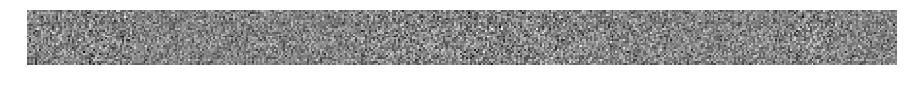

Epochs: 1.33 global_step: 2500 loss_D: 0.047 loss_G: 7.387 (9071.22 examples/sec; 0.004 sec/batch)


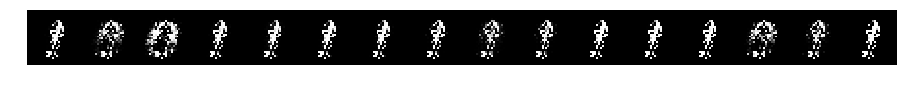

Epochs: 2.67 global_step: 5000 loss_D: 0.307 loss_G: 3.705 (5703.38 examples/sec; 0.006 sec/batch)


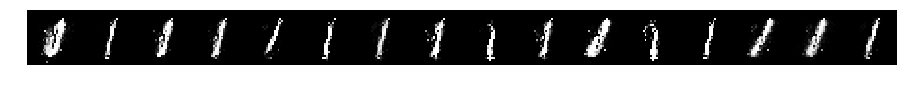

Epochs: 4.00 global_step: 7500 loss_D: 0.323 loss_G: 2.691 (7080.86 examples/sec; 0.005 sec/batch)


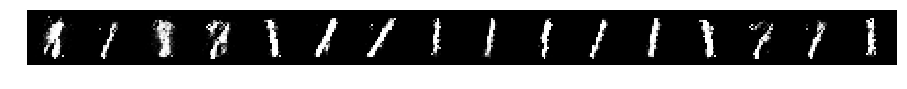

Epochs: 5.33 global_step: 10000 loss_D: 0.424 loss_G: 2.815 (6116.10 examples/sec; 0.005 sec/batch)


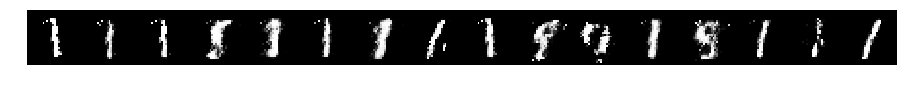

Epochs: 6.67 global_step: 12500 loss_D: 0.692 loss_G: 2.115 (8913.38 examples/sec; 0.004 sec/batch)


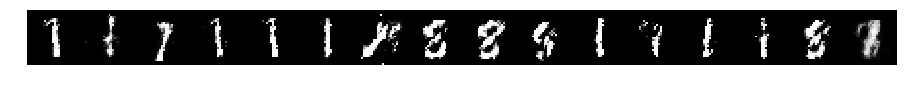

Epochs: 8.00 global_step: 15000 loss_D: 0.429 loss_G: 1.970 (9038.23 examples/sec; 0.004 sec/batch)


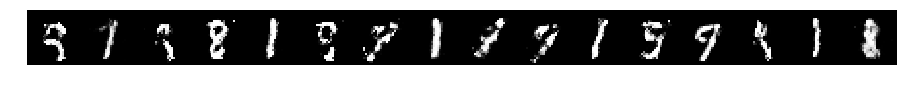

Epochs: 9.33 global_step: 17500 loss_D: 0.723 loss_G: 1.892 (8812.14 examples/sec; 0.004 sec/batch)


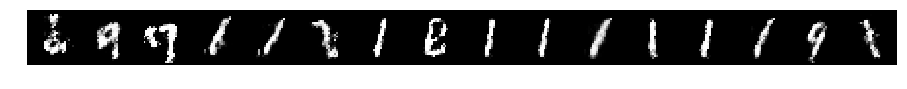

Epochs: 10.67 global_step: 20000 loss_D: 0.593 loss_G: 1.933 (6473.63 examples/sec; 0.005 sec/batch)


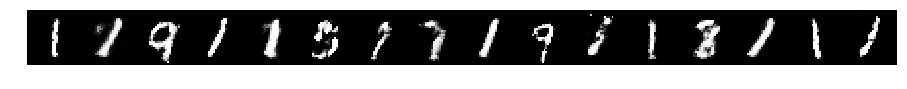

Epochs: 12.00 global_step: 22500 loss_D: 0.905 loss_G: 1.745 (8265.15 examples/sec; 0.004 sec/batch)


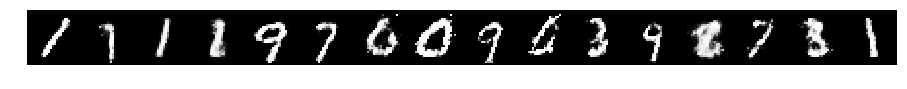

Epochs: 13.33 global_step: 25000 loss_D: 0.808 loss_G: 1.503 (8731.88 examples/sec; 0.004 sec/batch)


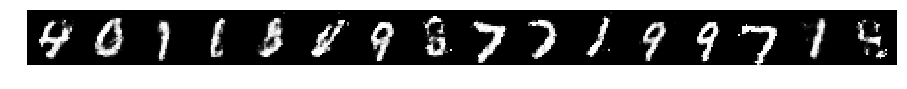

Epochs: 14.67 global_step: 27500 loss_D: 1.048 loss_G: 1.434 (7195.12 examples/sec; 0.004 sec/batch)


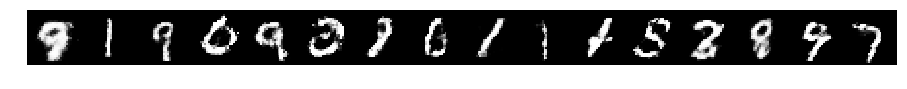

Epochs: 16.00 global_step: 30000 loss_D: 0.790 loss_G: 1.539 (6942.06 examples/sec; 0.005 sec/batch)


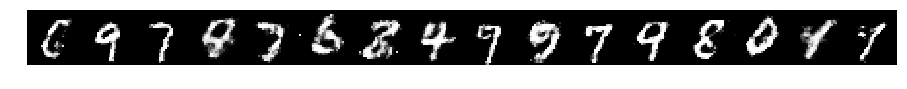

Epochs: 17.33 global_step: 32500 loss_D: 0.929 loss_G: 1.262 (7347.55 examples/sec; 0.004 sec/batch)


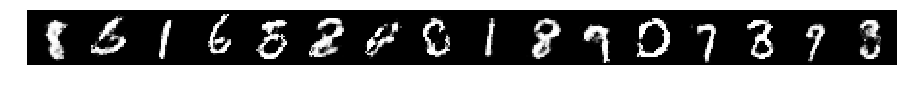

Epochs: 18.67 global_step: 35000 loss_D: 0.785 loss_G: 1.262 (7361.66 examples/sec; 0.004 sec/batch)


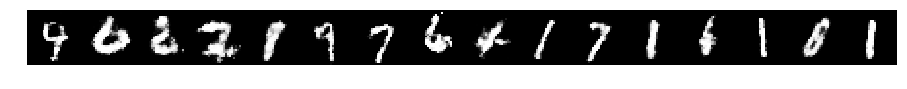

Epochs: 20.00 global_step: 37500 loss_D: 0.854 loss_G: 1.486 (5892.95 examples/sec; 0.005 sec/batch)


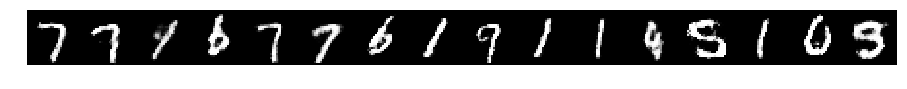

INFO:tensorflow:Saving model with global step 37500 (= 20 epochs) to disk.
Epochs: 21.33 global_step: 40000 loss_D: 1.018 loss_G: 1.429 (7656.46 examples/sec; 0.004 sec/batch)


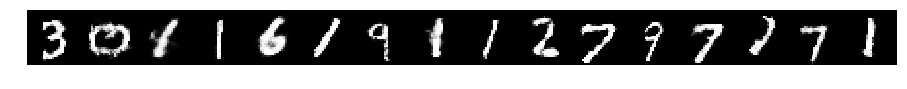

Epochs: 22.67 global_step: 42500 loss_D: 1.097 loss_G: 1.354 (7556.03 examples/sec; 0.004 sec/batch)


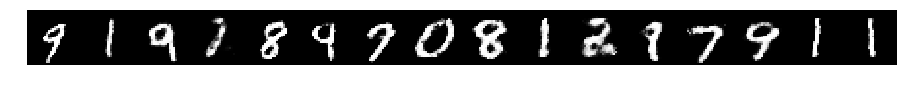

Epochs: 24.00 global_step: 45000 loss_D: 1.177 loss_G: 1.284 (8161.12 examples/sec; 0.004 sec/batch)


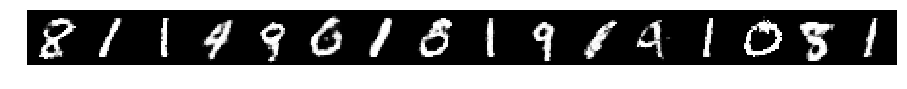

Epochs: 25.33 global_step: 47500 loss_D: 0.874 loss_G: 1.320 (7967.34 examples/sec; 0.004 sec/batch)


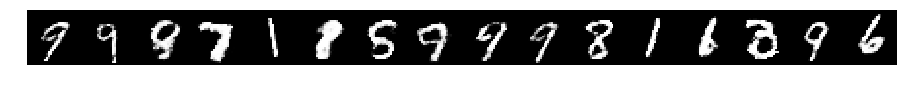

Epochs: 26.67 global_step: 50000 loss_D: 1.072 loss_G: 1.102 (5700.23 examples/sec; 0.006 sec/batch)


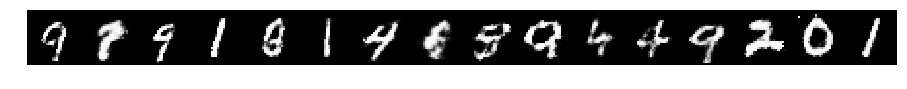

Epochs: 28.00 global_step: 52500 loss_D: 0.927 loss_G: 1.178 (8343.24 examples/sec; 0.004 sec/batch)


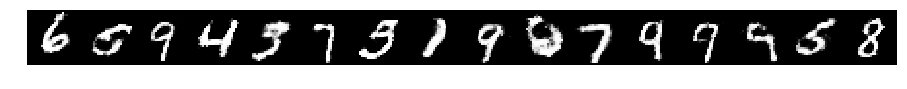

Epochs: 29.33 global_step: 55000 loss_D: 1.139 loss_G: 1.163 (7254.62 examples/sec; 0.004 sec/batch)


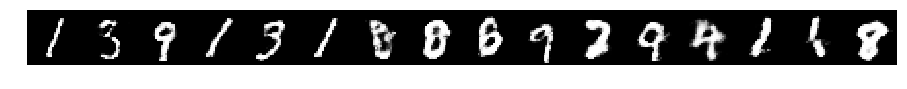

Epochs: 30.67 global_step: 57500 loss_D: 0.786 loss_G: 1.166 (5105.47 examples/sec; 0.006 sec/batch)


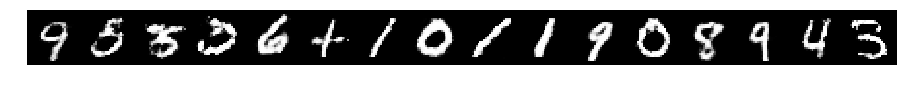

Epochs: 32.00 global_step: 60000 loss_D: 0.844 loss_G: 1.226 (7702.60 examples/sec; 0.004 sec/batch)


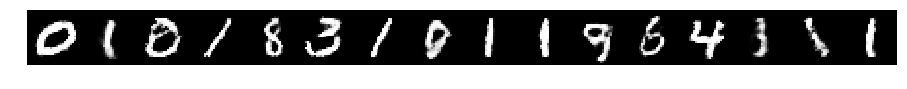

Epochs: 33.33 global_step: 62500 loss_D: 1.066 loss_G: 1.176 (8117.19 examples/sec; 0.004 sec/batch)


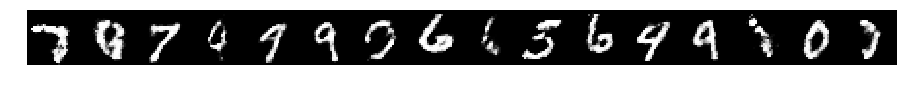

Epochs: 34.67 global_step: 65000 loss_D: 1.054 loss_G: 1.205 (8433.94 examples/sec; 0.004 sec/batch)


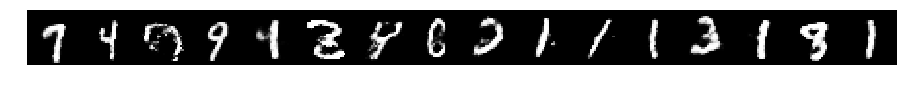

Epochs: 36.00 global_step: 67500 loss_D: 1.038 loss_G: 0.973 (6401.38 examples/sec; 0.005 sec/batch)


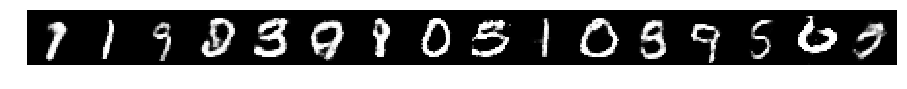

Epochs: 37.33 global_step: 70000 loss_D: 0.955 loss_G: 1.233 (7360.45 examples/sec; 0.004 sec/batch)


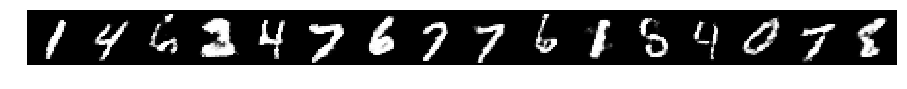

Epochs: 38.67 global_step: 72500 loss_D: 1.218 loss_G: 1.029 (8048.56 examples/sec; 0.004 sec/batch)


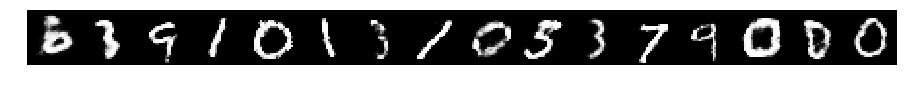

Epochs: 40.00 global_step: 75000 loss_D: 0.950 loss_G: 1.148 (8202.01 examples/sec; 0.004 sec/batch)


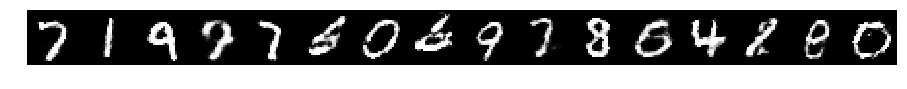

INFO:tensorflow:Saving model with global step 75000 (= 40 epochs) to disk.
Epochs: 41.33 global_step: 77500 loss_D: 1.152 loss_G: 1.479 (6991.60 examples/sec; 0.005 sec/batch)


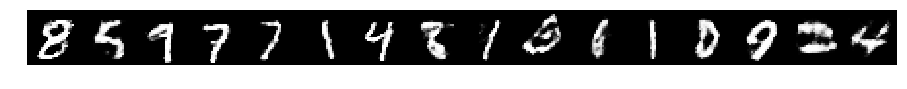

Epochs: 42.67 global_step: 80000 loss_D: 0.969 loss_G: 1.125 (8391.75 examples/sec; 0.004 sec/batch)


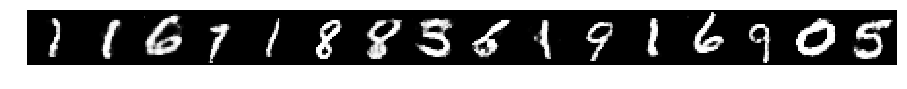

Epochs: 44.00 global_step: 82500 loss_D: 1.017 loss_G: 1.067 (7032.26 examples/sec; 0.005 sec/batch)


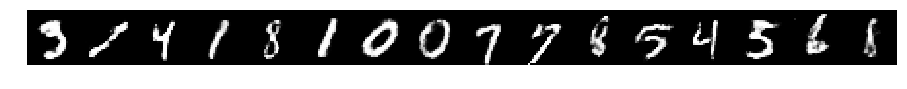

Epochs: 45.33 global_step: 85000 loss_D: 1.228 loss_G: 1.416 (5684.78 examples/sec; 0.006 sec/batch)


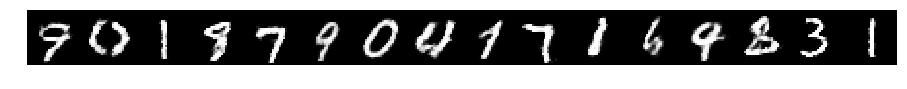

Epochs: 46.67 global_step: 87500 loss_D: 1.152 loss_G: 1.128 (6872.39 examples/sec; 0.005 sec/batch)


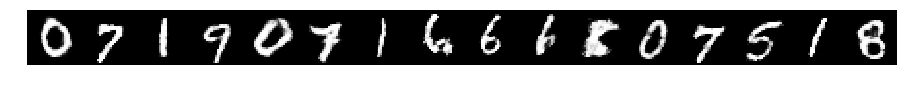

Epochs: 48.00 global_step: 90000 loss_D: 0.935 loss_G: 1.398 (6909.89 examples/sec; 0.005 sec/batch)


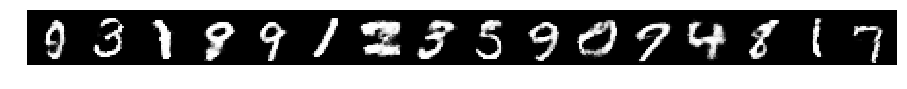

Epochs: 49.33 global_step: 92500 loss_D: 1.037 loss_G: 1.168 (8821.41 examples/sec; 0.004 sec/batch)


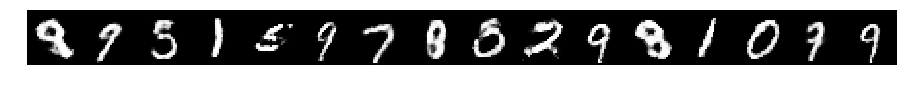

Epochs: 50.67 global_step: 95000 loss_D: 1.099 loss_G: 1.132 (7926.87 examples/sec; 0.004 sec/batch)


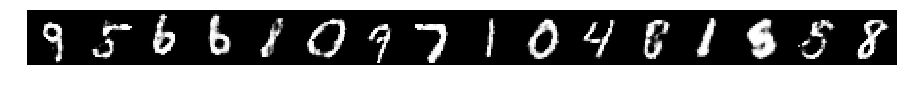

Epochs: 52.00 global_step: 97500 loss_D: 1.070 loss_G: 1.069 (8050.49 examples/sec; 0.004 sec/batch)


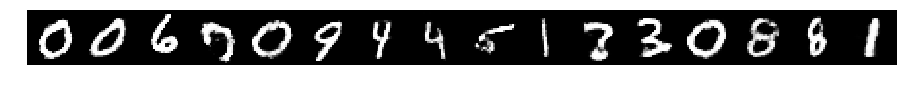

Epochs: 53.33 global_step: 100000 loss_D: 1.074 loss_G: 1.049 (8347.39 examples/sec; 0.004 sec/batch)


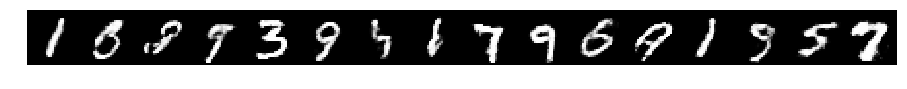

Epochs: 54.67 global_step: 102500 loss_D: 0.930 loss_G: 1.067 (8628.04 examples/sec; 0.004 sec/batch)


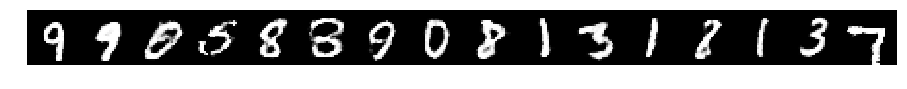

Epochs: 56.00 global_step: 105000 loss_D: 0.971 loss_G: 1.079 (8760.38 examples/sec; 0.004 sec/batch)


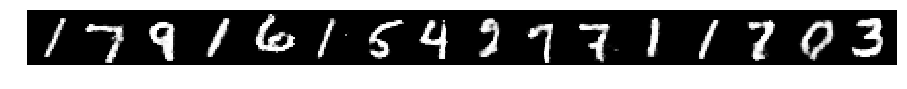

Epochs: 57.33 global_step: 107500 loss_D: 0.959 loss_G: 1.167 (7525.95 examples/sec; 0.004 sec/batch)


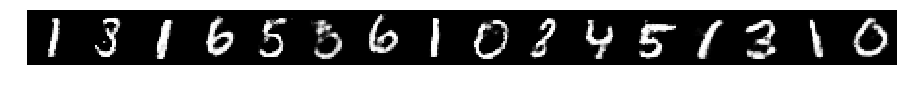

Epochs: 58.67 global_step: 110000 loss_D: 1.008 loss_G: 0.969 (9335.59 examples/sec; 0.003 sec/batch)


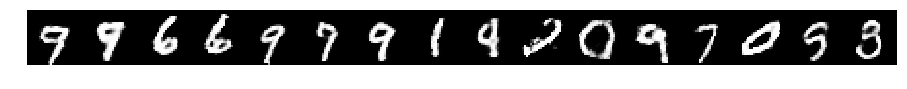

Epochs: 60.00 global_step: 112500 loss_D: 1.029 loss_G: 1.239 (7061.12 examples/sec; 0.005 sec/batch)


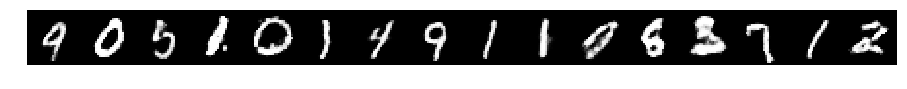

INFO:tensorflow:Saving model with global step 112500 (= 60 epochs) to disk.
Epochs: 61.33 global_step: 115000 loss_D: 1.173 loss_G: 1.204 (7440.83 examples/sec; 0.004 sec/batch)


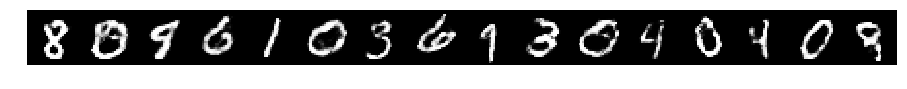

Epochs: 62.67 global_step: 117500 loss_D: 1.061 loss_G: 1.341 (5165.20 examples/sec; 0.006 sec/batch)


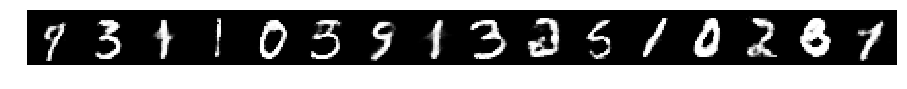

Epochs: 64.00 global_step: 120000 loss_D: 0.965 loss_G: 1.088 (8499.10 examples/sec; 0.004 sec/batch)


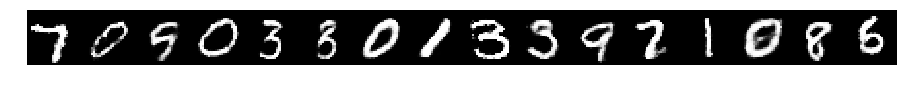

Epochs: 65.33 global_step: 122500 loss_D: 1.061 loss_G: 1.189 (6987.23 examples/sec; 0.005 sec/batch)


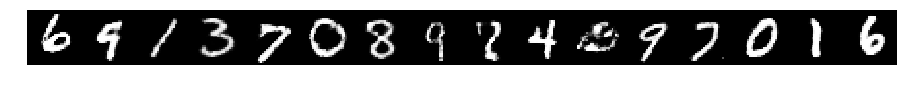

Epochs: 66.67 global_step: 125000 loss_D: 1.137 loss_G: 1.565 (8902.74 examples/sec; 0.004 sec/batch)


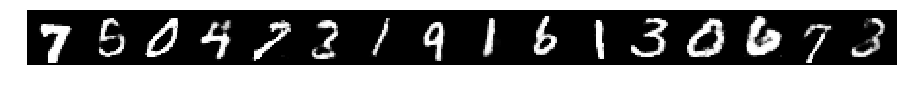

Epochs: 68.00 global_step: 127500 loss_D: 1.082 loss_G: 1.047 (5738.50 examples/sec; 0.006 sec/batch)


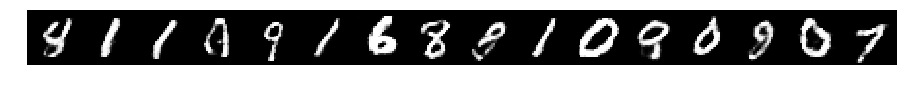

Epochs: 69.33 global_step: 130000 loss_D: 1.282 loss_G: 1.302 (7160.19 examples/sec; 0.004 sec/batch)


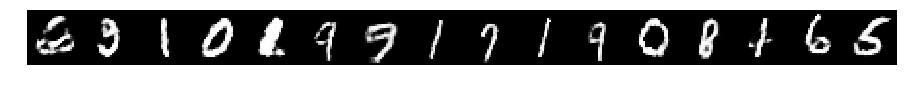

Epochs: 70.67 global_step: 132500 loss_D: 1.039 loss_G: 1.194 (5983.05 examples/sec; 0.005 sec/batch)


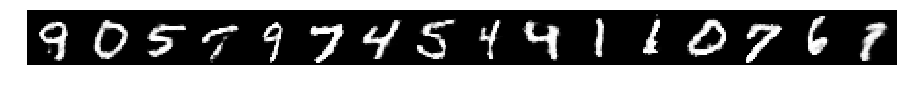

Epochs: 72.00 global_step: 135000 loss_D: 1.050 loss_G: 1.167 (5980.38 examples/sec; 0.005 sec/batch)


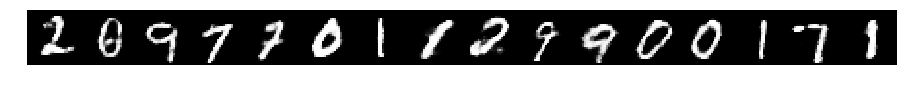

Epochs: 73.33 global_step: 137500 loss_D: 0.955 loss_G: 1.126 (8426.53 examples/sec; 0.004 sec/batch)


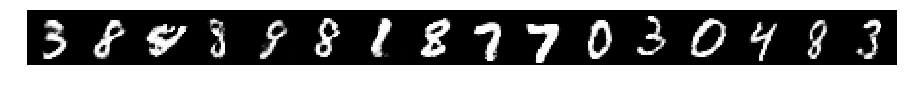

Epochs: 74.67 global_step: 140000 loss_D: 1.092 loss_G: 1.224 (7226.89 examples/sec; 0.004 sec/batch)


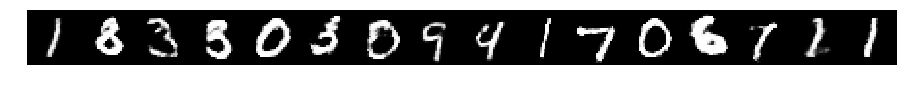

Epochs: 76.00 global_step: 142500 loss_D: 1.099 loss_G: 1.202 (8926.43 examples/sec; 0.004 sec/batch)


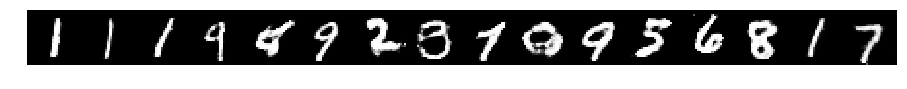

Epochs: 77.33 global_step: 145000 loss_D: 0.876 loss_G: 1.146 (8404.37 examples/sec; 0.004 sec/batch)


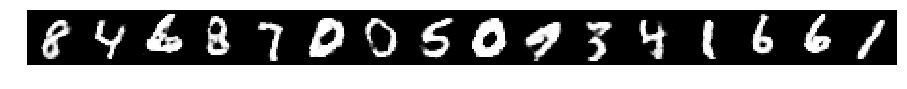

Epochs: 78.67 global_step: 147500 loss_D: 1.171 loss_G: 1.160 (8147.25 examples/sec; 0.004 sec/batch)


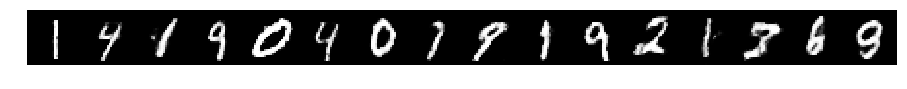

Epochs: 80.00 global_step: 150000 loss_D: 1.110 loss_G: 0.954 (6913.45 examples/sec; 0.005 sec/batch)


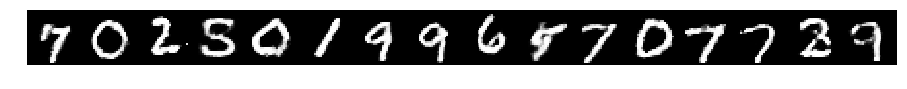

INFO:tensorflow:Saving model with global step 150000 (= 80 epochs) to disk.
Epochs: 81.33 global_step: 152500 loss_D: 0.936 loss_G: 1.243 (8793.67 examples/sec; 0.004 sec/batch)


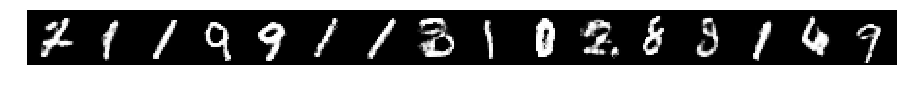

Epochs: 82.67 global_step: 155000 loss_D: 1.178 loss_G: 1.225 (5569.66 examples/sec; 0.006 sec/batch)


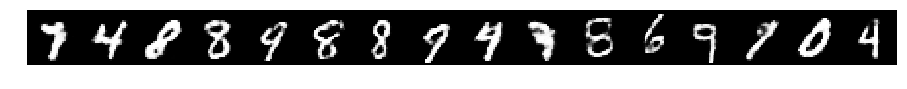

Epochs: 84.00 global_step: 157500 loss_D: 0.974 loss_G: 1.180 (8101.02 examples/sec; 0.004 sec/batch)


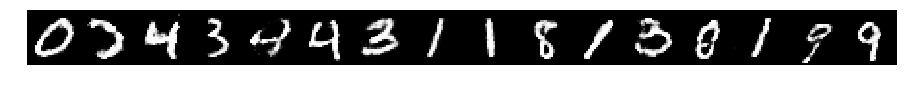

Epochs: 85.33 global_step: 160000 loss_D: 1.111 loss_G: 1.147 (9035.19 examples/sec; 0.004 sec/batch)


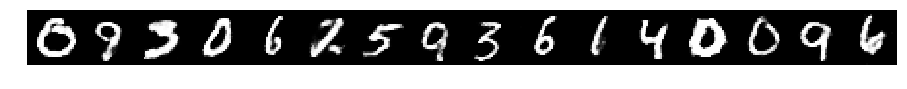

Epochs: 86.67 global_step: 162500 loss_D: 1.116 loss_G: 1.143 (6734.79 examples/sec; 0.005 sec/batch)


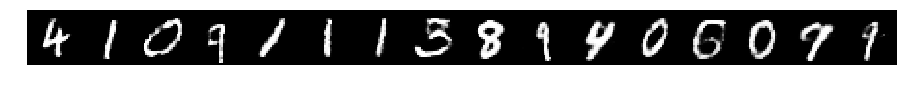

Epochs: 88.00 global_step: 165000 loss_D: 1.005 loss_G: 1.141 (7224.55 examples/sec; 0.004 sec/batch)


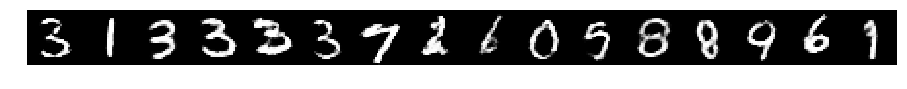

Epochs: 89.33 global_step: 167500 loss_D: 0.709 loss_G: 1.216 (7198.59 examples/sec; 0.004 sec/batch)


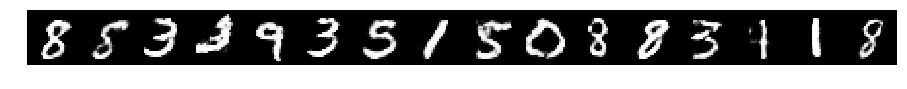

Epochs: 90.67 global_step: 170000 loss_D: 0.900 loss_G: 1.351 (8798.85 examples/sec; 0.004 sec/batch)


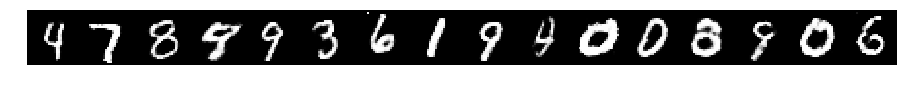

Epochs: 92.00 global_step: 172500 loss_D: 1.143 loss_G: 1.067 (6799.62 examples/sec; 0.005 sec/batch)


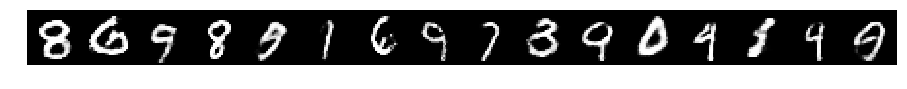

Epochs: 93.33 global_step: 175000 loss_D: 0.863 loss_G: 1.406 (7783.45 examples/sec; 0.004 sec/batch)


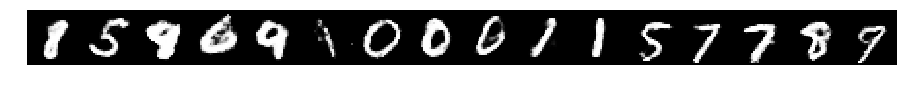

Epochs: 94.67 global_step: 177500 loss_D: 0.901 loss_G: 1.469 (5812.05 examples/sec; 0.006 sec/batch)


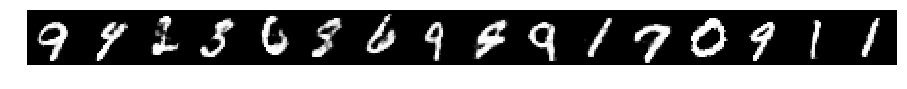

Epochs: 96.00 global_step: 180000 loss_D: 1.000 loss_G: 1.235 (6404.13 examples/sec; 0.005 sec/batch)


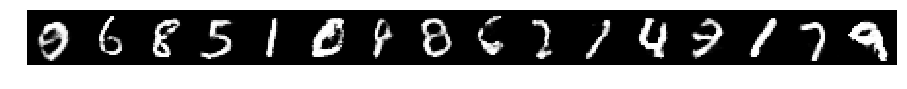

Epochs: 97.33 global_step: 182500 loss_D: 1.041 loss_G: 1.226 (7471.07 examples/sec; 0.004 sec/batch)


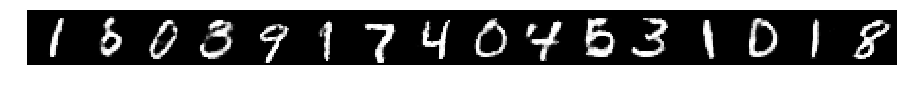

Epochs: 98.67 global_step: 185000 loss_D: 1.296 loss_G: 1.306 (7612.60 examples/sec; 0.004 sec/batch)


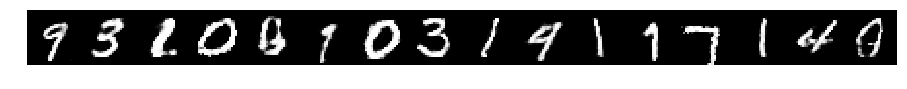

End of dataset
INFO:tensorflow:Saving model with global step 187461 (= 99 epochs) to disk.
INFO:tensorflow:complete training...


In [13]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
with tf.Session(config=sess_config) as sess:
  sess.run(tf.global_variables_initializer())
  tf.logging.info('Start Session.')
  
  num_examples = len(train_data)
  num_batches_per_epoch = int(num_examples / batch_size)
  
  # save loss values for plot
  loss_history = []
  pre_epochs = 0
  while True:
    try:
      start_time = time.time()
      
      for _ in range(k):
        _, loss_D = sess.run([opt_D_op, model.loss_Discriminator])
      _, global_step_, loss_G = sess.run([opt_G_op,
                                          model.global_step,
                                          model.loss_Generator])
      
      epochs = global_step_ * batch_size / float(num_examples)
      duration = time.time() - start_time

      if global_step_ % print_steps == 0:
        examples_per_sec = batch_size / float(duration)
        print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                  epochs, global_step_, loss_D, loss_G, examples_per_sec, duration))

        loss_history.append([epochs, loss_D, loss_G])

        # print sample data
        sample_data = sess.run(model.sample_data)
        print_sample_data(sample_data)

      # write summaries periodically
      if global_step_ % summary_steps == 0:
        summary_str = sess.run(summary_op)
        train_writer.add_summary(summary_str, global_step=global_step_)

      # save model checkpoint periodically
      if int(epochs) % save_epochs == 0  and  pre_epochs != int(epochs):
        tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
        saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
        pre_epochs = int(epochs)
        
    except tf.errors.OutOfRangeError:
      print("End of dataset")  # ==> "End of dataset"
      tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
      saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
      break
      
  tf.logging.info('complete training...')

## Plot loss functions

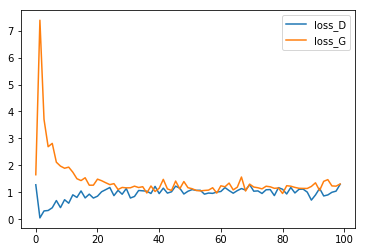

In [14]:
loss_history = np.asarray(loss_history)

plt.plot(loss_history[:,0], loss_history[:,1], label='loss_D')
plt.plot(loss_history[:,0], loss_history[:,2], label='loss_G')
plt.legend(loc='upper right')
plt.show()